In [7]:
import tensorflow as tf
from glob import glob
import os
import random
import numpy as np
import cv2
from skimage.io import imread, imshow
from PIL import Image
from matplotlib import pyplot as plt
import imageio
from tqdm import tqdm
from skimage.transform import resize
from google.colab import drive

In [8]:
seed = 42
np.random.seed = seed

In [9]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

Load data

In [10]:
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/DatasetRetina' 

train_x = sorted(glob(os.path.join(data_path, "training", "images", "*.tif")))
train_y = sorted(glob(os.path.join(data_path, "training", "1st_manual", "*.gif")))

test_x = sorted(glob(os.path.join(data_path, "test", "images", "*.tif")))
test_y = sorted(glob(os.path.join(data_path, "test", "1st_manual", "*.gif")))

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train: 20 - 20
Test: 20 - 20


In [11]:
if not os.path.exists("new_data/train/image"):
    os.makedirs("new_data/train/image")
if not os.path.exists("new_data/train/mask"):    
    os.makedirs("new_data/train/mask")
if not os.path.exists("new_data/test/image"):
    os.makedirs("new_data/test/image")
if not os.path.exists("new_data/test/mask"):
    os.makedirs("new_data/test/mask")



New JPEG Training data

In [12]:
for idx, (x, y) in tqdm(enumerate(zip(train_x, train_y)), total=len(test_x)):
    x = x.replace('\\', '/')
    y = y.replace('\\', '/')
    name = x.split("/")[-1].split(".")[0]
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = imageio.mimread(y)[0]
    X = [x]
    Y = [y]
    for i, m in zip(X, Y):
        i = cv2.resize(i, (IMG_WIDTH, IMG_HEIGHT))
        m = cv2.resize(m, (IMG_WIDTH, IMG_HEIGHT))
        tmp_image_name = f"{name}.jpg"
        tmp_mask_name = f"{name}.jpg"
        image_path = os.path.join("new_data/train/", "image", tmp_image_name)
        mask_path = os.path.join("new_data/train/", "mask", tmp_mask_name)
        cv2.imwrite(image_path, i)
        cv2.imwrite(mask_path, m)

100%|██████████| 20/20 [00:01<00:00, 13.27it/s]


New JPEG Testing data

In [13]:
for idx, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(train_x)):
    x = x.replace('\\', '/')
    y = y.replace('\\', '/')
    name = x.split("/")[-1].split(".")[0]
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = imageio.mimread(y)[0]
    X = [x]
    Y = [y]
    for i, m in zip(X, Y):
        i = cv2.resize(i, (IMG_WIDTH, IMG_HEIGHT))
        m = cv2.resize(m, (IMG_WIDTH, IMG_HEIGHT))
        tmp_image_name = f"{name}.jpg"
        tmp_mask_name = f"{name}.jpg"
        image_path = os.path.join("new_data/test/", "image", tmp_image_name)
        mask_path = os.path.join("new_data/test/", "mask", tmp_mask_name)
        cv2.imwrite(image_path, i)
        cv2.imwrite(mask_path, m)

100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Filling arrays of X_train and y_train

In [14]:
TRAIN_PATH = 'new_data/train/'
TEST_PATH = 'new_data/test/'

train_images = TRAIN_PATH + 'image/'
train_masks = TRAIN_PATH + 'mask/'
test_images = TEST_PATH + 'image/'
test_masks = TEST_PATH + 'mask/'

train_ids = next(os.walk(train_images))[2]
train_mask_ids = next(os.walk(train_masks))[2]
test_ids = next(os.walk(test_images))[2]
test_mask_ids = next(os.walk(test_masks))[2]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)

for n, id_ in enumerate(train_ids):   
    path = train_images + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    X_train[n] = img  #Fill empty X_train with values from img

for n, id_ in enumerate(train_mask_ids):
    path = train_masks + id_
    mask_ = imread(path)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    y_train[n] = mask_

for n, id_ in enumerate(test_ids):   
    path = test_images + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    X_test[n] = img

<ipython-input-14-ab5f940652a9>:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


Build model

In [15]:



inp = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))


conv1 = tf.keras.layers.Conv2D(64, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(inp)
conv1 = tf.keras.layers.Conv2D(64, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(conv1)
pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(128, (3, 3), 
                               activation='relu', 
                               kernel_initializer='he_normal', 
                               padding='same'
                               )(pool1)
conv2 = tf.keras.layers.Conv2D(128, (3, 3), 
                               activation='relu', 
                               kernel_initializer='he_normal', 
                               padding='same'
                               )(conv2)
pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
 
conv3 = tf.keras.layers.Conv2D(256, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(pool2)
conv3 = tf.keras.layers.Conv2D(256, (3, 3), 
                               activation='relu', 
                               kernel_initializer='he_normal', 
                               padding='same'
                               )(conv3)
pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
 
conv4 = tf.keras.layers.Conv2D(512, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(pool3)
conv4 = tf.keras.layers.Conv2D(512, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(conv4)
drop4 = tf.keras.layers.Dropout(0.2)(conv4)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)
 
conv5 = tf.keras.layers.Conv2D(1024, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(pool4)
conv5 = tf.keras.layers.Conv2D(1024, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(conv5)
drop5 = tf.keras.layers.Dropout(0.3)(conv5)



up6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
merge6 = tf.keras.layers.concatenate([up6, drop4])
conv6 = tf.keras.layers.Conv2D(512, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(merge6)
conv6 = tf.keras.layers.Conv2D(512, (3, 3), 
                               activation='relu', 
                               kernel_initializer='he_normal', 
                               padding='same'
                               )(conv6)
 
up7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
merge7 = tf.keras.layers.concatenate([up7, conv3])
conv7 = tf.keras.layers.Conv2D(256, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(merge7)
conv7 = tf.keras.layers.Conv2D(256, (3, 3), 
                               activation='relu', 
                               kernel_initializer='he_normal', 
                               padding='same'
                               )(conv7)
 
up8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
merge8 = tf.keras.layers.concatenate([up8, conv2])
conv8 = tf.keras.layers.Conv2D(128, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(merge8)
conv8 = tf.keras.layers.Conv2D(128, (3, 3), 
                               activation='relu', 
                               kernel_initializer='he_normal', 
                               padding='same'
                               )(conv8)
 
up9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
merge9 = tf.keras.layers.concatenate([up9, conv1], axis=3)
conv9 = tf.keras.layers.Conv2D(64, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(merge9)
conv9 = tf.keras.layers.Conv2D(64, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(conv9)
conv9 = tf.keras.layers.Conv2D(2, (3, 3), 
                            activation='relu', 
                            kernel_initializer='he_normal', 
                            padding='same'
                            )(conv9)

out = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
model = tf.keras.Model(inputs=[inp], outputs=[out])
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

Add checkpoints

In [16]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'retina model.h5', 
    verbose = 1, 
    save_best_only = True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, y_train, validation_split=0.1, batch_size=4, epochs=5, callbacks=callbacks)

Epoch 1/5
5/5 [==============================] - 57s 4s/step - loss: 13.4372 - accuracy: 0.6608 - val_loss: 0.6918 - val_accuracy: 0.8056
Epoch 2/5
5/5 [==============================] - 5s 890ms/step - loss: 0.6914 - accuracy: 0.7907 - val_loss: 0.6905 - val_accuracy: 0.8056
Epoch 3/5
5/5 [==============================] - 5s 894ms/step - loss: 0.6902 - accuracy: 0.7907 - val_loss: 0.6892 - val_accuracy: 0.8056
Epoch 4/5
5/5 [==============================] - 5s 896ms/step - loss: 0.6889 - accuracy: 0.7907 - val_loss: 0.6878 - val_accuracy: 0.8056
Epoch 5/5
5/5 [==============================] - 5s 898ms/step - loss: 0.6876 - accuracy: 0.7907 - val_loss: 0.6865 - val_accuracy: 0.8056


In [17]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 33s 33s/step


Check random examples

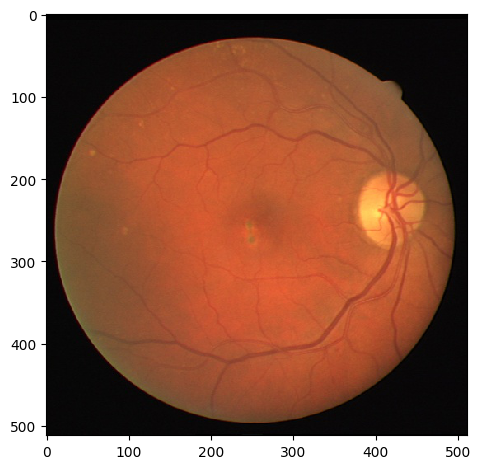

In [18]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])

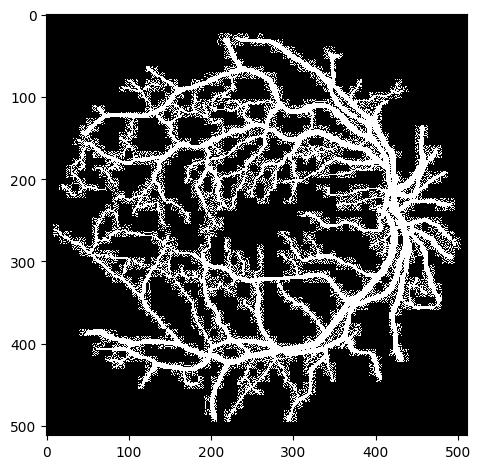

In [19]:
imshow(np.squeeze(y_train[ix]))

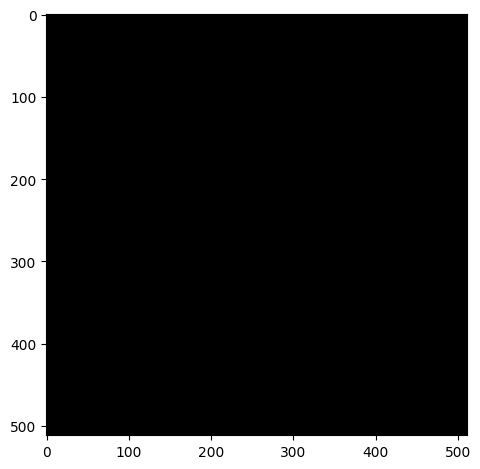

In [20]:
imshow(np.squeeze(preds_train_t[ix]))